In [1]:
import pandas as pd
import os
import shutil
import cv2
from multiprocessing import Pool
import time
import process_images_448_448
import process_images_128_128
import gc
import matplotlib.pyplot as plt
import random

In [2]:
train_file_csv_df = pd.read_csv("train.csv")

In [3]:
landmarks_greater_than_5_df = train_file_csv_df.landmark_id.value_counts().reset_index(name="count").query('count>5')
print("Sample of record in the train_file_csv_df dataframe : \n" + str(train_file_csv_df.head(1)))
print("Total number of images in the training set : " + str(train_file_csv_df['url'].count()))
print("Total number of unique landmark_ids in the training dataset : " + str(train_file_csv_df.landmark_id.value_counts()
                                                                                 .reset_index(name="count")["index"].count()))
print("Total number of landmarks with greater than 5 images in the dataset : " + str(landmarks_greater_than_5_df["index"].count()))

Sample of record in the train_file_csv_df dataframe : 
                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
Total number of images in the training set : 4132914
Total number of unique landmark_ids in the training dataset : 203094
Total number of landmarks with greater than 5 images in the dataset : 125731


In [4]:
filtered_train_greater_than_5_df = train_file_csv_df[train_file_csv_df.landmark_id.isin(landmarks_greater_than_5_df['index'])]
print("Total number of images for landmarks with image count of greater than 5 in the training set after filtering  : " + str(filtered_train_greater_than_5_df["id"].count()))
print(filtered_train_greater_than_5_df.head(1))
print(filtered_train_greater_than_5_df.iloc[1]['url'])

Total number of images for landmarks with image count of greater than 5 in the training set after filtering  : 3920020
                 id                                                url  \
0  6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   

   landmark_id  
0       142820  
http://upload.wikimedia.org/wikipedia/commons/6/63/Ecosse200996-1.jpg


In [5]:
imageIds_landmarkIds_dict = filtered_train_greater_than_5_df.set_index('id')['landmark_id'].to_dict()
len(imageIds_landmarkIds_dict)

3920020

In [6]:
# del train_file_csv_df
gc.collect()

40

In [7]:
landmarkIds_counts_df = pd.DataFrame(filtered_train_greater_than_5_df.landmark_id.value_counts())
landmarkIds_counts_df = landmarkIds_counts_df.rename(columns={'landmark_id':'counts'})
landmarkIds_counts_df.reset_index(level=0, inplace=True)
landmarkIds_counts_df = landmarkIds_counts_df.rename(columns={'index':'landmark_id'})
landmarkIds_counts_df['landmark_id'] = landmarkIds_counts_df['landmark_id'].astype('str')
print(len(landmarkIds_counts_df))
landmarkIds_counts_dict = landmarkIds_counts_df.set_index('landmark_id')['counts'].to_dict()

125731


In [8]:
landmarkIds_counts_df[:2]

,landmark_id,counts
0,138982,10247
1,62798,4333


(array([68977., 15913.,  6259.,  3175.,  1757.,  1178.,   744.,   464.,
          298.,   235.]),
 array([  8.,  33.,  58.,  83., 108., 133., 158., 183., 208., 233., 258.]),
 <a list of 10 Patch objects>)

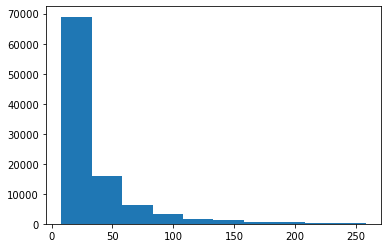

In [10]:
plt.hist(landmarkIds_counts_df.counts[1000:100000])
# plt.bar(df.landmark_id,df.counts)

In [11]:
# Now, filter out images where each landmark has only 500 or less images to prevent overfitting on larger set of landmark_ids.
total_landmarks_less_than_100_count = landmarkIds_counts_df[landmarkIds_counts_df.counts<=100].count()
total_landmarks_less_than_100_count

landmark_id    119329
counts         119329
dtype: int64

In [12]:
total_landmarks_less_than_10_count = landmarkIds_counts_df[landmarkIds_counts_df.counts<10]
total_landmarks_less_than_10_count.count()

landmark_id    32991
counts         32991
dtype: int64

In [13]:
# total number of images where landmarks have less than 10 images
total_images_less_than_10 = 0
for item in total_landmarks_less_than_10_count.counts: 
    total_images_less_than_10 +=item
total_images_less_than_10

241819

In [14]:
greater_100 = landmarkIds_counts_df[landmarkIds_counts_df.counts>100]
greater_100.count()

landmark_id    6402
counts         6402
dtype: int64

In [15]:
# Number of extra images over 100 for the landmarks where landmark has more than 100 images
total_images_greater_than100 = 0
for item in greater_100.counts:
    diff = item-100
    total_images_greater_than100 +=diff
total_images_greater_than100

613962

In [16]:
greater_than_10 = landmarkIds_counts_df[landmarkIds_counts_df.counts>=10]
greater_than_10.count()

landmark_id    92740
counts         92740
dtype: int64

In [17]:
total_number_of_images_100orless = 0
for item in greater_than_10.counts:
    if item>100:
        total_number_of_images_100orless += 100
    else:
        total_number_of_images_100orless += item
print(total_number_of_images_100orless)
    

3064239


In [47]:
greater_than_10.landmark_id.count()

92740

In [35]:
j=0
k=4637
total = 0
for i in range(1,21):
    l = k*i
    print("start (j) = ", j , ", end (l) = ", l)
    total_number_of_images_100orless = 0
    for item in greater_than_10.counts[j:l]:
        if item>100:
            total_number_of_images_100orless += 100
        else:
            total_number_of_images_100orless += item
    total += total_number_of_images_100orless
    print("Number of images : ", total_number_of_images_100orless)
    j=l
print("Total : ",total)


start (j) =  0 , end (l) =  4637
Number of images :  463700
start (j) =  4637 , end (l) =  9274
Number of images :  433344
start (j) =  9274 , end (l) =  13911
Number of images :  323212
start (j) =  13911 , end (l) =  18548
Number of images :  253814
start (j) =  18548 , end (l) =  23185
Number of images :  209758
start (j) =  23185 , end (l) =  27822
Number of images :  178328
start (j) =  27822 , end (l) =  32459
Number of images :  154759
start (j) =  32459 , end (l) =  37096
Number of images :  136482
start (j) =  37096 , end (l) =  41733
Number of images :  121182
start (j) =  41733 , end (l) =  46370
Number of images :  108693
start (j) =  46370 , end (l) =  51007
Number of images :  98077
start (j) =  51007 , end (l) =  55644
Number of images :  89212
start (j) =  55644 , end (l) =  60281
Number of images :  81136
start (j) =  60281 , end (l) =  64918
Number of images :  74451
start (j) =  64918 , end (l) =  69555
Number of images :  68047
start (j) =  69555 , end (l) =  74192


In [1]:
zip_files_list = list()
for i in range(1,21):
    zip_files_list.append("set_128_" + str(i) + ".zip")
zip_files_list

['set_128_1.zip',
 'set_128_2.zip',
 'set_128_3.zip',
 'set_128_4.zip',
 'set_128_5.zip',
 'set_128_6.zip',
 'set_128_7.zip',
 'set_128_8.zip',
 'set_128_9.zip',
 'set_128_10.zip',
 'set_128_11.zip',
 'set_128_12.zip',
 'set_128_13.zip',
 'set_128_14.zip',
 'set_128_15.zip',
 'set_128_16.zip',
 'set_128_17.zip',
 'set_128_18.zip',
 'set_128_19.zip',
 'set_128_20.zip']

In [4]:
# Create 7 groups of data to train 7 different models based on the number of available smples for each label
groups = [(1,2),(3,5),(6,8),(9,11),(12,14),(15,17),(18,20)]
for index, group in enumerate(groups[1:]):
    print(group[0])
    for zip_file in zip_files_list[group[0]-1:group[1]]:
        local_zip = 'datasets/' + zip_file
        print(local_zip)
#         zip_ref = zipfile.ZipFile(local_zip, 'r')
        location_to_zip = 'datasets/group' + str(index+2) +'_set_128/'
        print(location_to_zip)

3
datasets/set_128_3.zip
datasets/group2_set_128/
datasets/set_128_4.zip
datasets/group2_set_128/
datasets/set_128_5.zip
datasets/group2_set_128/
6
datasets/set_128_6.zip
datasets/group3_set_128/
datasets/set_128_7.zip
datasets/group3_set_128/
datasets/set_128_8.zip
datasets/group3_set_128/
9
datasets/set_128_9.zip
datasets/group4_set_128/
datasets/set_128_10.zip
datasets/group4_set_128/
datasets/set_128_11.zip
datasets/group4_set_128/
12
datasets/set_128_12.zip
datasets/group5_set_128/
datasets/set_128_13.zip
datasets/group5_set_128/
datasets/set_128_14.zip
datasets/group5_set_128/
15
datasets/set_128_15.zip
datasets/group6_set_128/
datasets/set_128_16.zip
datasets/group6_set_128/
datasets/set_128_17.zip
datasets/group6_set_128/
18
datasets/set_128_18.zip
datasets/group7_set_128/
datasets/set_128_19.zip
datasets/group7_set_128/
datasets/set_128_20.zip
datasets/group7_set_128/
